In [2]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))
## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Notebook Last Run Initiated: 2022-06-13 16:06:30.975894


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [105]:
# define documents
data = pd.read_csv('data\ZIP_TRACT_122021.csv',dtype={
                     'zip': str,
                     'tract': str,
                     'usps_zip_pref_city': str,
                     'usps_zip_pref_state': str,
                     'res_ratio': float,
                     'bus_ratio': float,
                     'oth_ratio': float,
                     'tot_ratio': float})

geodata = pd.read_csv('data\ZIP2LATLON_VER1.csv',dtype={
                      'postal_code': str,
                      'country_code': str,
                      'place': str,
                      'state': str,
                      'statecode': str,
                      'province_or_county': str,
                      'province_or_countycode': str,
                      'latitude': float,
                      'longitude': float})

geodata['postal_code'] = geodata['postal_code'].str.zfill(5)

In [106]:
data = pd.merge(data, geodata,  how='left', left_on=['zip'], right_on = ['postal_code'])
data = data.drop(['res_ratio', 'bus_ratio', 'oth_ratio', 'postal_code','country_code', 'state', 'statecode', 'province_or_countycode', 'place'], axis=1)
data = data.fillna(0)

In [107]:
data = data[['zip','tract','usps_zip_pref_city','usps_zip_pref_state','province_or_county','latitude','longitude','tot_ratio']]
target = data['tot_ratio']
ndata = data[['latitude','longitude']]

In [108]:
ndata = StandardScaler().fit_transform(ndata.values)

In [109]:
docs = data.iloc[:,0:4].apply(lambda x: ' '.join(x), axis=1)

In [110]:
# integer encode the documents
vocab_size = 131322
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(docs)

In [111]:
encoded_docs = t.texts_to_sequences(docs)

In [112]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [113]:
def BuildModel(learning_rate):
        
    input_text  = tf.keras.layers.Input(shape=(max_length,),name='text')
    input_float = tf.keras.layers.Input(shape=(2,),name='float')

    n = tf.keras.layers.BatchNormalization()(input_float)
    
    x = tf.keras.layers.Embedding(vocab_size, 20, input_length=max_length,name='embeddings')(input_text)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Concatenate(axis=1,name='concat')([n,x])
    #x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(40, activation='relu',name='act01')(x)
    output = tf.keras.layers.Dense(1, activation='linear',name='linear_output')(x)
    
    model = Model([input_text,input_float],output)
    
    model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate))
    return model

In [114]:
learning_rate = 1e-3
n_epochs = 250

model = BuildModel(learning_rate)
        
ckp_path = f'models/Model_02.hdf5'

cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.4, patience = 5, verbose = 0, min_delta = 0.0001, mode = 'min')
        
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=0, patience=10, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(ckp_path, monitor='loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True)
        
    #tb_cb = tf.keras.callbacks.TensorBoard(log_dir="logs")

# train the model
model.fit([padded_docs,ndata],target,epochs=n_epochs, batch_size=128,
          callbacks=[mc,cb_lr_schedule,es], shuffle=False,
          workers=-1, use_multiprocessing=True, verbose=2)
        


Epoch 1/250
1346/1346 - 10s - loss: 0.0948 - lr: 0.0010 - 10s/epoch - 7ms/step
Epoch 2/250
1346/1346 - 9s - loss: 0.0609 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 3/250
1346/1346 - 9s - loss: 0.0380 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 4/250
1346/1346 - 9s - loss: 0.0248 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 5/250
1346/1346 - 9s - loss: 0.0203 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 6/250
1346/1346 - 9s - loss: 0.0187 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 7/250
1346/1346 - 9s - loss: 0.0169 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 8/250
1346/1346 - 9s - loss: 0.0148 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 9/250
1346/1346 - 9s - loss: 0.0133 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 10/250
1346/1346 - 9s - loss: 0.0127 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 11/250
1346/1346 - 9s - loss: 0.0110 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 12/250
1346/1346 - 9s - loss: 0.0112 - lr: 0.0010 - 9s/epoch - 7ms/step
Epoch 13/250
1346/1346 - 9s - loss: 0.0096 - lr: 0.0010 - 9s/epoch - 7m

In [116]:
# evaluate the model
loss = model.evaluate([padded_docs,ndata], target, verbose=2)
print(loss)

5381/5381 - 9s - loss: 0.0291 - 9s/epoch - 2ms/step
0.02914256975054741


In [117]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 4)]          0           []                               
                                                                                                  
 float (InputLayer)             [(None, 2)]          0           []                               
                                                                                                  
 embeddings (Embedding)         (None, 4, 20)        2626440     ['text[0][0]']                   
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 2)           8           ['float[0][0]']                  
 rmalization)                                                                               

In [118]:
embedding_layer = model.get_layer('embeddings')

In [119]:
embeddings = embedding_layer.get_weights()[0]

In [120]:
np.savetxt("embeddings_model3.csv", embeddings, delimiter=",")

In [121]:
embeddings[t.word_index['60126'],:]

array([-0.05331505,  0.31715432, -0.01677282,  0.13675012, -0.0207196 ,
       -0.155846  ,  0.19207096,  0.2805058 , -0.03249141, -0.42619672,
        0.30113244, -0.17950575, -0.32420534,  0.18050355,  0.06761418,
        0.20329346, -0.03852167, -0.00806461,  0.11836513, -0.20754945],
      dtype=float32)

In [138]:
cosine_similarity(np.reshape(embeddings[t.word_index['60126'],:],(1,20)),np.reshape(embeddings[t.word_index['68823'],:],(1,20)))[0][0]

0.30922157

In [137]:
1. - cdist(np.reshape(embeddings[t.word_index['60126'],:],(1,20)), np.reshape(embeddings[t.word_index['60164'],:],(1,20)), 'cosine')[0][0]

0.23714384742126016

In [124]:
states = pd.DataFrame(pd.unique(data.usps_zip_pref_state),columns=['states'])

In [125]:
states_list = []

for index, row in states.iterrows():
    state = row[0].lower()
    states_list.append(pd.concat([pd.Series(state), pd.DataFrame(np.reshape(embeddings[t.word_index[state],:],(1,20)))   ],axis=1))   

In [126]:
states = pd.concat(states_list)
states = states.reset_index(drop=True)

In [127]:
states.columns = range(states.columns.size)

In [128]:
x = StandardScaler().fit_transform(states.iloc[:,1:-1].values)

In [129]:
pca = PCA(n_components=2)

In [130]:
principalComponents = pca.fit_transform(x)

In [131]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [132]:
finalDf = pd.concat([principalDf, states.iloc[:,0]], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'State']

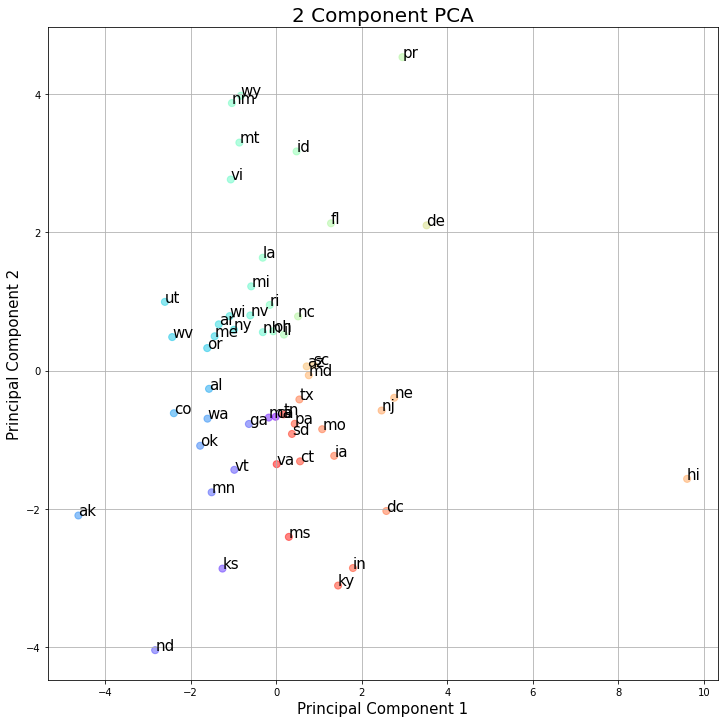

In [133]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

plt.scatter(finalDf.iloc[:,0], finalDf.iloc[:,1], c=np.arctan2(finalDf.iloc[:,0], finalDf.iloc[:,1]),cmap='rainbow', s=50, alpha=0.5)

ax.grid()

for i, txt in enumerate(finalDf.iloc[:,2]):
    ax.annotate(txt, (finalDf.iloc[i,0], finalDf.iloc[i,1]),fontsize=15)
